In [ ]:
#Installations

#!pip install emoji

In [ ]:
#Environment details

In [ ]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.semi_supervised import LabelPropagation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.model_selection import train_test_split
import nltk

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Loading the dataset
path = os.getcwd()
dataset_path = path + '/dataset'
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_rating
0,What is THE best question to ask on a job inte...,One that has always gone over well for me:\n\n...,7,1047,9.0
1,What is THE best question to ask on a job inte...,"When you were interviewing here, what would yo...",9,2625,6.0
2,What is THE best question to ask on a job inte...,Ask them what is the biggest problem you can s...,9,1669,7.0
3,What is THE best question to ask on a job inte...,A question that landed me a job once was:\n“If...,6,712,8.0
4,What is THE best question to ask on a job inte...,I like to ask:\n\n1. How is success measured i...,6,593,7.0


In [ ]:
df.shape

(7938, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7938 non-null   object 
 1   reply             7937 non-null   object 
 2   replies_count     7938 non-null   int64  
 3   up_counts         7938 non-null   int64  
 4   relevance_rating  4832 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 310.2+ KB


- Basic Pre-processing

In [ ]:
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [ ]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [ ]:
#Drop duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [ ]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [ ]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    #Removing the emojis
    text = emoji.demojize(text)
    return text
df['comment'] = df['comment'].apply(clean_text)

In [ ]:
print(df.sample(n=5))

                                               question  \
4241  What is a Pokemon you love that isn't very pop...   
6137            What is your favourite game of all time   
6093            What is your favourite game of all time   
6334            What is your favourite game of all time   
6903            What is your favourite game of all time   

                                                comment  replies_count  score  \
4241                                            Kartana              0      1   
6137                               Farming simulator 22              0      1   
6093                                   Age of Empires 2              0      1   
6334  Silent Hill 2. What, a video game with subtext...              0      1   
6903  I really think ODST is totally underrated. Yea...              1      1   

      relevance_rating  
4241               NaN  
6137               6.0  
6093               6.0  
6334               6.0  
6903               NaN  


In [ ]:
#Checking the target.
df['relevance_rating'].value_counts()

relevance_rating
1.0     992
6.0     840
7.0     595
8.0     587
9.0     417
10.0    357
3.0     225
5.0     214
2.0     212
4.0     156
0.0      74
Name: count, dtype: int64

There are null values and 0 as well when the considered scale is from 1-10.

In [ ]:
#replacing the 0s with 1s
df['relevance_rating'] = df['relevance_rating'].replace(0.0, 1.0)
df['relevance_rating'].value_counts()

relevance_rating
1.0     1066
6.0      840
7.0      595
8.0      587
9.0      417
10.0     357
3.0      225
5.0      214
2.0      212
4.0      156
Name: count, dtype: int64

Imbalanced data based on the relevance_ratings.

- Visualizations

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [ ]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.describe()

,replies_count,score,relevance_rating
count,7571.000000,7571.000000,4669.000000
mean,0.433100,11.222956,5.372242
std,1.451773,77.151973,3.051719
min,0.000000,-62.000000,1.000000
25%,0.000000,1.000000,2.000000
50%,0.000000,1.000000,6.000000
75%,0.000000,3.000000,8.000000
max,54.000000,2916.000000,10.000000


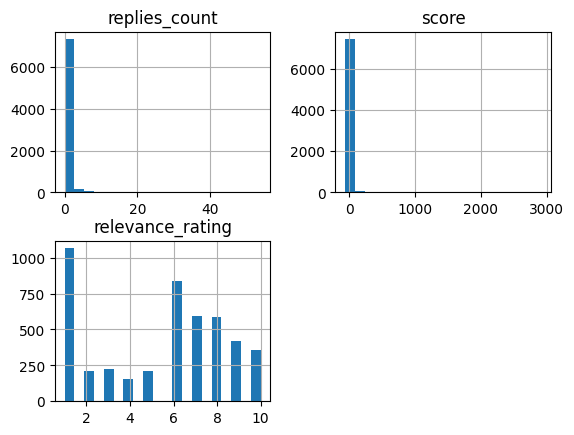

In [ ]:
#Continuous values
df.hist(bins = 20)
plt.show()

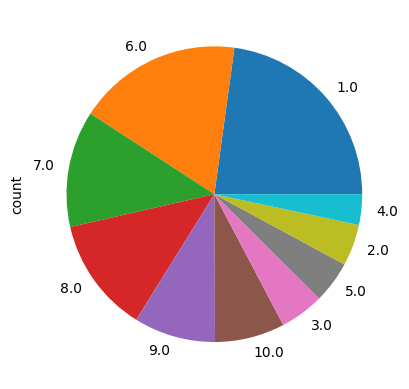

In [ ]:
df['relevance_rating'].value_counts().plot.pie()
plt.show()

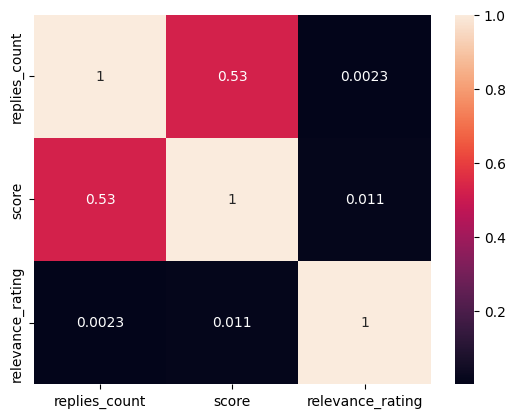

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

In [ ]:
#Just for visualization:
df['question'].value_counts()

question
What is a Pokemon you love that isn't very popular or talked about?        2491
What is your favourite game of all time                                    1251
What do y’all think is the Best iphone 15 pro max color?                    898
Which cities in America is baseball more popular than football?             888
What is THE best question to ask on a job interview?                        671
Most job interviews are harder than the job itself                          344
Anyone else feel like LinkedIn is overrated to job searching?               330
What are your favorite gadgets that make life just a little bit easier?     259
What's YOUR favourite food?                                                 205
Is Youtube music better than Spotify?                                       134
Is baseball poorly designed?                                                100
Name: count, dtype: int64

In [ ]:
label_encoder = LabelEncoder()
df_question_encoded = df.copy()
df_question_encoded['question'] = label_encoder.fit_transform(df_question_encoded['question'])

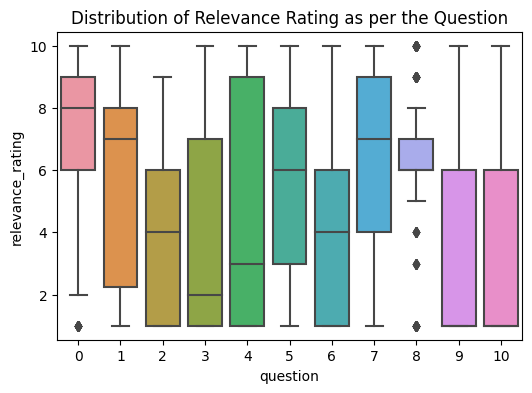

In [ ]:
#Distribution of relevance_rating as per the questions.
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_question_encoded, x='question', y='relevance_rating')
plt.title('Distribution of Relevance Rating as per the Question')
plt.show()

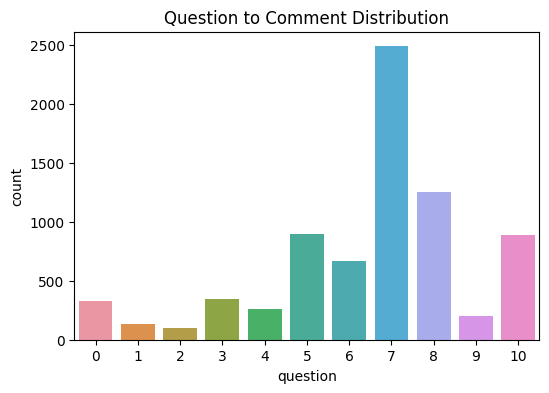

In [ ]:
#Distribution of comments as per questions.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_question_encoded, x='question')
plt.title('Question to Comment Distribution')
plt.show()

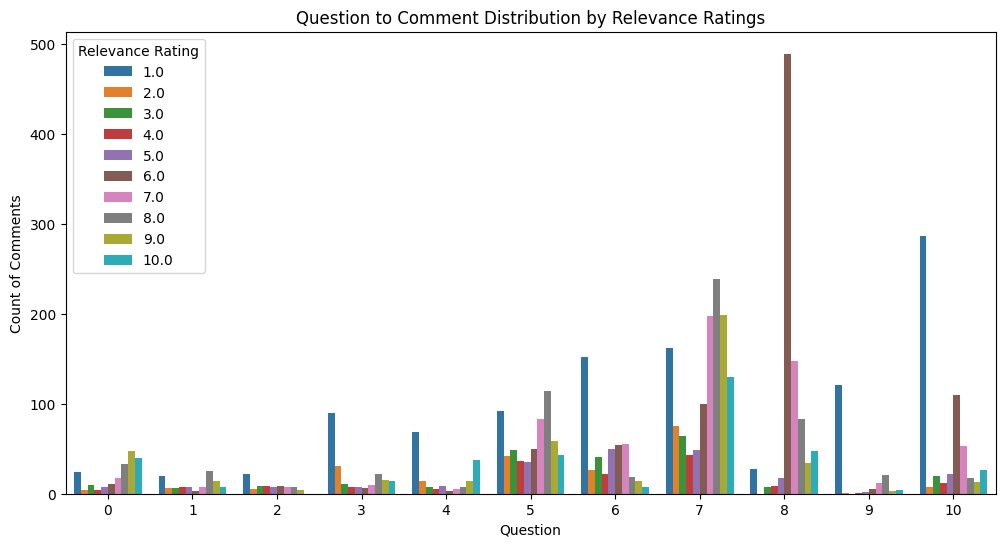

In [ ]:
#Question to Comment Distribution divided by Relevance Ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_question_encoded, x='question', hue='relevance_rating')
plt.title('Question to Comment Distribution by Relevance Ratings')
plt.xlabel('Question')
plt.ylabel('Count of Comments')
plt.legend(title='Relevance Rating')
plt.show()

In [ ]:
df.isnull().sum()

question               0
comment                0
replies_count          0
score                  0
relevance_rating    2902
dtype: int64

In [ ]:
#deleting rows with comment length equal to or less than 3
df = df[df['comment'].apply(lambda x: len(x.split()) > 3)]

Label propagation-1 (doubt)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features_labeled = tfidf_vectorizer.fit_transform(df.loc[df['relevance_rating'].notnull(), 'comment'])

In [ ]:
tfidf_features_labeled.shape

(4136, 9986)

In [ ]:
similarity_matrix = cosine_similarity(tfidf_features_labeled)

In [ ]:
# Extract labeled features and labels
features_labeled = tfidf_features_labeled
labels_labeled = df.loc[df['relevance_rating'].notnull(), 'relevance_rating']

In [ ]:
labels_labeled.shape

(4136,)

In [ ]:
unlabeled_data = df[df['relevance_rating'].isnull()]

In [ ]:
tfidf_features_unlabeled = tfidf_vectorizer.transform(unlabeled_data['comment'])

In [ ]:
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=5)
label_prop_model.fit(features_labeled, labels_labeled)

LabelPropagation(kernel='knn', n_neighbors=5)

In [ ]:
propagated_labels = label_prop_model.transduction_

In [ ]:
unlabeled_df = df[df['relevance_rating'].isnull()].copy()

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features_unlabeled = tfidf_vectorizer.fit_transform(df['comment'])

In [ ]:
unlabeled_df['propagated_label'] = propagated_labels[:len(unlabeled_df)]

In [ ]:
unlabeled_df.head()

,question,comment,replies_count,score,relevance_rating,propagated_label
0,What is THE best question to ask on a job inte...,"nice, Yeah a few weeks ago my company (psychia...",1,29,NaN,10.0
5,What is THE best question to ask on a job inte...,"Many times I’ve been hiring, I’m looking for a...",1,0,NaN,1.0
6,What is a Pokemon you love that isn't very pop...,Popplio. People prefer primarina,0,1,NaN,1.0
8,What do y’all think is the Best iphone 15 pro ...,"IMO, the blue looks really good but I think I'...",0,1,NaN,3.0
12,What do y’all think is the Best iphone 15 pro ...,"For me, it’s the Natural color",0,2,NaN,7.0


In [ ]:
unlabeled_df.to_excel(path+"\\predictions\\unlabeled_data_1.xlsx", index=False)

In [ ]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    return compound_score

In [ ]:
def keyword_presence(comment, title):
    # Preprocess comment and title: remove punctuation and convert to lowercase
    comment = re.sub(r'[^\w\s]', '', comment.lower())
    title = re.sub(r'[^\w\s]', '', title.lower())

    # Split title into individual words
    title_words = set(title.split())

    # Check if any keyword from title is present in comment
    for word in title_words:
        if word in comment:
            return True
    return False

In [ ]:
def create_features(data):
    data['sentiment'] = data['comment'].apply(get_sentiment_score)
    data['comment_length'] = data['comment'].apply(len)     # Length of comment
    data['num_upvotes'] = data['score']
    data['num_replies'] = data['replies_count']
    # Check if keywords from the post title are present in the comment
    data['keyword_presence'] = data.apply(lambda row: keyword_presence(row['comment'], row['question']), axis=1)

    return data

In [ ]:
# Feature engineering
df = create_features(df)

In [ ]:
labeled_data = df[df['relevance_rating'].notnull()]
unlabeled_data = df[df['relevance_rating'].isnull()]

In [ ]:
# Define features and labels for labeled data
labeled_features = labeled_data[['comment', 'sentiment', 'num_upvotes', 'num_replies', 'keyword_presence']]
labeled_labels = labeled_data['relevance_rating']

In [ ]:
# Define features for unlabeled data
unlabeled_features = unlabeled_data[['comment', 'sentiment', 'num_upvotes', 'num_replies', 'keyword_presence']]

In [ ]:
# Train TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(labeled_features['comment'])

In [ ]:
# Instantiate LabelPropagation model
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=5)

In [ ]:
print(labeled_features.dtypes)

comment              object
sentiment           float64
num_upvotes           int64
num_replies           int64
keyword_presence       bool
dtype: object


In [ ]:
# Preprocess comment text
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(labeled_features['comment'])

# Combine text features with other numerical features
other_features = labeled_features.drop(columns=['comment'])
combined_features = np.hstack((comment_vectors.toarray(), other_features))

# Fit the label propagation model on combined features
label_prop_model.fit(combined_features, labeled_labels)


LabelPropagation(kernel='knn', n_neighbors=5)

In [ ]:
# Preprocess comment text for unlabeled data
unlabeled_comment_vectors = vectorizer.transform(unlabeled_features['comment'])

# Combine text features with other numerical features for unlabeled data
unlabeled_other_features = unlabeled_features.drop(columns=['comment'])
combined_unlabeled_features = np.hstack((unlabeled_comment_vectors.toarray(), unlabeled_other_features))

# Predict relevance scores for unlabeled data
predicted_relevance = label_prop_model.predict(combined_unlabeled_features)

In [ ]:
# Assign predicted relevance scores to unlabeled data
unlabeled_data['predicted_relevance'] = predicted_relevance

# Save unlabeled data with predicted relevance scores to Excel
unlabeled_data.to_excel(path+'\\predictions\\unlabeled_data_with_predictions_2.xlsx', index=False)

Label propagation-3 (using similarity only between comments)

In [ ]:
labeled_sentiments = labeled_data['comment'].apply(get_sentiment_score)
unlabeled_sentiments = unlabeled_data['comment'].apply(get_sentiment_score)

In [ ]:
labeled_df = pd.DataFrame({'comment': labeled_data['comment'], 'sentiment': labeled_sentiments, 'relevance_rating': labeled_data['relevance_rating']})
unlabeled_df = pd.DataFrame({'question': unlabeled_data['question'], 'comment': unlabeled_data['comment'], 'sentiment': unlabeled_sentiments})

In [ ]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_labeled = tfidf_vectorizer.fit_transform(labeled_df['comment'])
tfidf_matrix_unlabeled = tfidf_vectorizer.transform(unlabeled_df['comment'])

In [ ]:
# Word2Vec
word2vec_model = Word2Vec(sentences=labeled_df['comment'], vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

In [ ]:
def get_word2vec_vector(comment, word_vectors):
  comment_vector = np.zeros(word_vectors.vector_size)  # Initialize with zeros
  word_count = 0
  for word in comment.split():
    if word in word_vectors:
      comment_vector += word_vectors[word]
      word_count += 1
  if word_count > 0:  # Check if any words were found in vocabulary
    comment_vector /= word_count  # Take the mean if there are valid words
  return comment_vector

In [ ]:
def get_word2vec_similarity(comment, labeled_comments, word_vectors):
    comment_vector = get_word2vec_vector(comment, word_vectors)
    labeled_comment_vectors = np.array([get_word2vec_vector(c, word_vectors) for c in labeled_comments])
    similarities = cosine_similarity([comment_vector], labeled_comment_vectors)
    return similarities[0]

In [ ]:
labeled_comment_vectors = np.array([np.mean([word_vectors[word] for word in comment.split() if word in word_vectors], axis=0) for comment in labeled_data['comment']])
unlabeled_comment_vectors = np.array([np.mean([word_vectors[word] for word in comment.split() if word in word_vectors], axis=0) for comment in unlabeled_data['comment']])

In [ ]:
labeled_comment_vectors = np.nan_to_num(labeled_comment_vectors)
unlabeled_comment_vectors = np.nan_to_num(unlabeled_comment_vectors)

In [ ]:
# Sample a subset of labeled data with a similar size to unlabeled data
labeled_subset = labeled_data.sample(len(unlabeled_data))
labeled_comment_vectors_subset = np.array([get_word2vec_vector(comment, word_vectors) for comment in labeled_subset['comment']])

In [ ]:
# Calculate Word2Vec similarities
word2vec_similarities = cosine_similarity(unlabeled_comment_vectors, labeled_comment_vectors)

In [ ]:
word2vec_similarities_subset = cosine_similarity(unlabeled_comment_vectors, labeled_comment_vectors_subset)

In [ ]:
# Doc2Vec
tagged_documents = [TaggedDocument(words=comment.split(), tags=[str(i)]) for i, comment in enumerate(labeled_data['comment'])]
doc2vec_model = Doc2Vec(tagged_documents, vector_size=100, window=5, min_count=1, workers=4)

labeled_comments = labeled_data['comment']
doc2vec_similarities = np.array([doc2vec_model.infer_vector(comment.split()) for comment in labeled_comments])

In [ ]:
# Label Propagation with TF-IDF
label_prop_model_tfidf = LabelPropagation(kernel='knn', n_neighbors=5)
label_prop_model_tfidf.fit(tfidf_matrix_labeled, labeled_df['relevance_rating'])
predicted_labels_tfidf = label_prop_model_tfidf.predict(tfidf_matrix_unlabeled)

In [ ]:
predictions_tfidf = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction_tfidf': predicted_labels_tfidf
})
predictions_tfidf.to_excel(path+"\predictions\labels_tfidf.xlsx", index=False)

In [ ]:
#Label Propagation with word2vec
label_prop_model_word2vec = LabelPropagation(kernel='knn', n_neighbors=5)
label_prop_model_word2vec.fit(word2vec_similarities_subset, labeled_subset['relevance_rating'])
predicted_labels_word2vec = label_prop_model_word2vec.predict(word2vec_similarities_subset)

In [ ]:
predictions_word2vec = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction_word2vec': predicted_labels_word2vec
})
predictions_word2vec.to_excel(path+"\predictions\labels_word2vec.xlsx", index=False)

In [ ]:
# Label Propagation with doc2vec similarities
label_prop_model_doc2vec = LabelPropagation(kernel='knn', n_neighbors=5)
label_prop_model_doc2vec.fit(doc2vec_similarities, labeled_data['relevance_rating'])

# Predict relevance scores for unlabeled data using doc2vec similarities
unlabeled_doc2vec_similarities = np.array([doc2vec_model.infer_vector(comment.split()) for comment in unlabeled_data['comment']])
predicted_labels_doc2vec = label_prop_model_doc2vec.predict(unlabeled_doc2vec_similarities)

In [ ]:
predictions_doc2vec = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction_doc2vec': predicted_labels_doc2vec
})
predictions_doc2vec.to_excel(path+"\predictions\labels_doc2vec.xlsx", index=False)

In [ ]:
# Convert predictions to integers
predicted_labels_tfidf_int = predicted_labels_tfidf.astype(int)
predicted_labels_word2vec_int = predicted_labels_word2vec.astype(int)
predicted_labels_doc2vec_int = predicted_labels_doc2vec.astype(int)

# Combine Predictions
combined_predictions = np.vstack([predicted_labels_tfidf_int, predicted_labels_word2vec_int, predicted_labels_doc2vec_int])
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined_predictions)

In [ ]:
unlabeled_with_predictions = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction': final_predictions
})
unlabeled_with_predictions.to_excel(path+"\\predictions\\combined_labels.xlsx", index=False)

In [ ]:
# Combine Predictions-word2vec,doc2vec
combined_predictions_vec = np.vstack([predicted_labels_doc2vec_int, predicted_labels_word2vec_int])
final_predictions_vec = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined_predictions)

In [ ]:
preds_vec = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction_vec': final_predictions_vec
})
preds_vec.to_excel(path+"\predictions\labels_vec.xlsx", index=False)

In [ ]:
model_weights = {
  'tfidf_model': 0.1,
  'word2vec_model': 0.3,
  'doc2vec_model': 0.6,
}
# Combine predictions with weights
combined_predictions = np.vstack([predicted_labels_tfidf_int, predicted_labels_word2vec_int, predicted_labels_doc2vec_int])
weighted_predictions = np.average(combined_predictions, axis=0, weights=list(model_weights.values()))
final_predictions_weighted = np.round(weighted_predictions).astype(int)  # Round and convert to integer class labels

In [ ]:
unlabeled_with_predictions_weighted = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction': final_predictions
})
unlabeled_with_predictions_weighted.to_excel(path+"\\predictions\\combined_labels_weighted.xlsx", index=False)

In [ ]:
#label prediction with voting
def voting(predictions):
    final_predictions, _ = mode(predictions, axis=0)
    return final_predictions.flatten()

final_predictions_voting = voting(combined_predictions)

In [ ]:
unlabeled_with_predictions_voting = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction': final_predictions_voting
})
unlabeled_with_predictions_voting.to_excel(path+"\predictions\labels_voting.xlsx", index=False)


In [ ]:
#label predictions-averaging
def averaging(predictions):
    # Take average of predictions along axis 0
    final_predictions = np.mean(predictions, axis=0)
    return final_predictions

final_predictions_averaging = averaging(combined_predictions)

In [ ]:
unlabeled_with_predictions_averaging = pd.DataFrame({
    'question': unlabeled_df['question'],
    'comment': unlabeled_df['comment'],
    'final_prediction': final_predictions_averaging
})
unlabeled_with_predictions_averaging.to_excel(path+"\predictions\labels_averaging.xlsx", index=False)